In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [12]:
warnings.filterwarnings('ignore')
dataframe = pd.read_csv(r"cbedatafinal2.csv")
dataframe = dataframe.dropna()
y_raw = dataframe['churn']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
columns_to_drop = ["OPENING_DATE", "AccountNumber", "Tenure", "current balance", "TXN_AMOUNT", "churn"]
features = dataframe.drop(columns=columns_to_drop, errors='ignore')
categorical_features = ["type of account", "INACTIVE", "Mobile user", "has ATM CARD", "CURRENCY", "Job type", "GENDER"]
X = pd.get_dummies(features, columns=categorical_features, drop_first=True, dtype=int)
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)


In [13]:

svm_base = SVC(kernel='rbf', probability=True, random_state=42)
svm_base.fit(X_train_scaled, y_train)
y_pred_base = svm_base.predict(X_test_scaled)
acc_base = accuracy_score(y_test, y_pred_base)
print('Baseline (Scaled, no PCA) Accuracy:', acc_base)
pca_full = PCA()
pca_full.fit(X_train_scaled)
exp_var_ratio = pca_full.explained_variance_ratio_
cum_exp_var = np.cumsum(exp_var_ratio)
target_var = 0.95
k = int(np.searchsorted(cum_exp_var, target_var) + 1)
print(f'Chosen n_components to reach {target_var*100:.0f}% variance:', k)
pca = PCA(n_components=k)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
svm_pca = SVC(kernel='rbf', probability=True, random_state=42)
svm_pca.fit(X_train_pca, y_train)
y_pred_pca = svm_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)
print('PCA + SVM Accuracy:', acc_pca)
cm_base = confusion_matrix(y_test, y_pred_base)
cm_pca = confusion_matrix(y_test, y_pred_pca)


Baseline (Scaled, no PCA) Accuracy: 0.933
Chosen n_components to reach 95% variance: 10
PCA + SVM Accuracy: 0.933


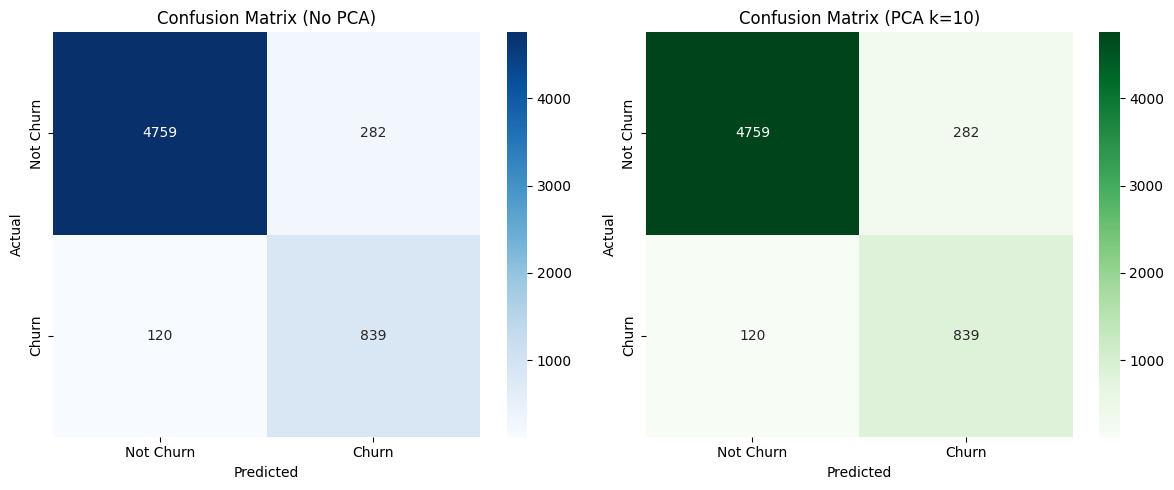

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn','Churn'], yticklabels=['Not Churn','Churn'])
plt.title('Confusion Matrix (No PCA)')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.subplot(1,2,2)
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Churn','Churn'], yticklabels=['Not Churn','Churn'])
plt.title(f'Confusion Matrix (PCA k={k})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
probas_base = svm_base.decision_function(X_test_scaled)
fpr_base, tpr_base, _ = roc_curve(y_test, probas_base)
roc_auc_base = auc(fpr_base, tpr_base)

probas_pca = svm_pca.decision_function(X_test_pca)
fpr_pca, tpr_pca, _ = roc_curve(y_test, probas_pca)
roc_auc_pca = auc(fpr_pca, tpr_pca)

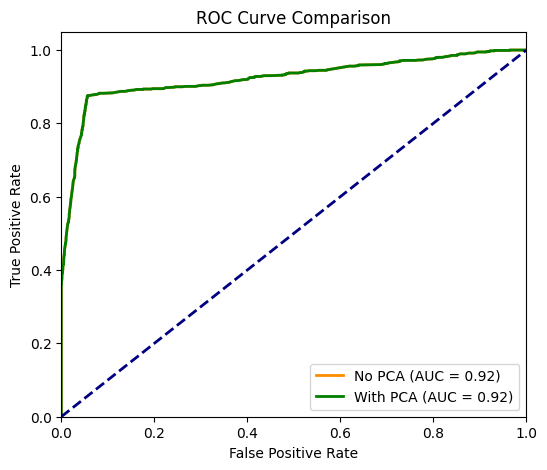

Classification Report (No PCA):
              precision    recall  f1-score   support

   Not Churn       0.98      0.94      0.96      5041
       Churn       0.75      0.87      0.81       959

    accuracy                           0.93      6000
   macro avg       0.86      0.91      0.88      6000
weighted avg       0.94      0.93      0.94      6000

Classification Report (With PCA):
              precision    recall  f1-score   support

   Not Churn       0.98      0.94      0.96      5041
       Churn       0.75      0.87      0.81       959

    accuracy                           0.93      6000
   macro avg       0.86      0.91      0.88      6000
weighted avg       0.94      0.93      0.94      6000



In [15]:


plt.figure(figsize=(6,5))
plt.plot(fpr_base, tpr_base, color='darkorange', lw=2, label=f'No PCA (AUC = {roc_auc_base:.2f})')
plt.plot(fpr_pca, tpr_pca, color='green', lw=2, label=f'With PCA (AUC = {roc_auc_pca:.2f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()
print("Classification Report (No PCA):")
print(classification_report(y_test, y_pred_base, target_names=['Not Churn', 'Churn']))

print("Classification Report (With PCA):")
print(classification_report(y_test, y_pred_pca, target_names=['Not Churn', 'Churn']))


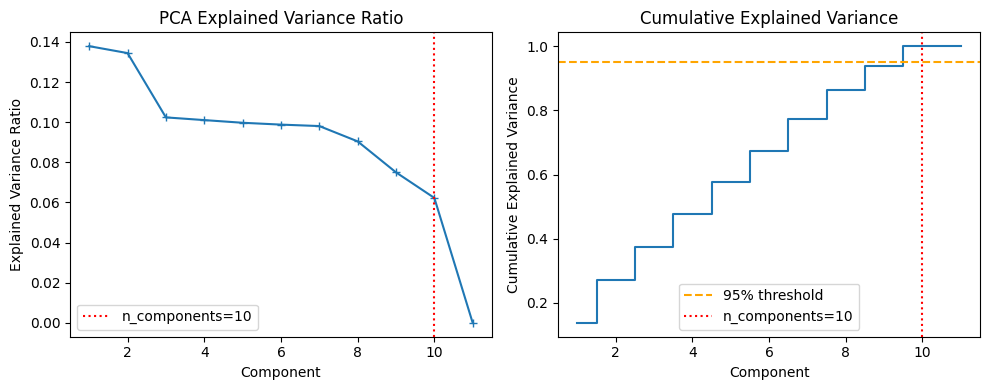

In [16]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(np.arange(1, len(exp_var_ratio)+1), exp_var_ratio, marker='+')
plt.xlabel('Component'); plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.axvline(k, linestyle=':', color='red', label=f'n_components={k}')
plt.legend()

plt.subplot(1,2,2)
plt.step(np.arange(1, len(cum_exp_var)+1), cum_exp_var, where='mid')
plt.xlabel('Component'); plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.axhline(target_var, linestyle='--', color='orange', label=f'{target_var*100:.0f}% threshold')
plt.axvline(k, linestyle=':', color='red', label=f'n_components={k}')
plt.legend()
plt.tight_layout()
plt.show()


In [17]:


if pca_full.n_components_ >= 2:
    # Use first two PCs from a PCA fitted on all scaled train features
    pca2 = PCA(n_components=2)
    X_train_pc2 = pca2.fit_transform(X_train_scaled)
    X_test_pc2 = pca2.transform(X_test_scaled)

    svm2 = SVC(kernel='rbf', random_state=42)
    svm2.fit(X_train_pc2, y_train)

    # Decision boundary mesh
    h = 0.02
    x_min, x_max = X_train_pc2[:, 0].min() - 1, X_train_pc2[:, 0].max() + 1
    y_min, y_max = X_train_pc2[:, 1].min() - 1, X_train_pc2[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svm2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)


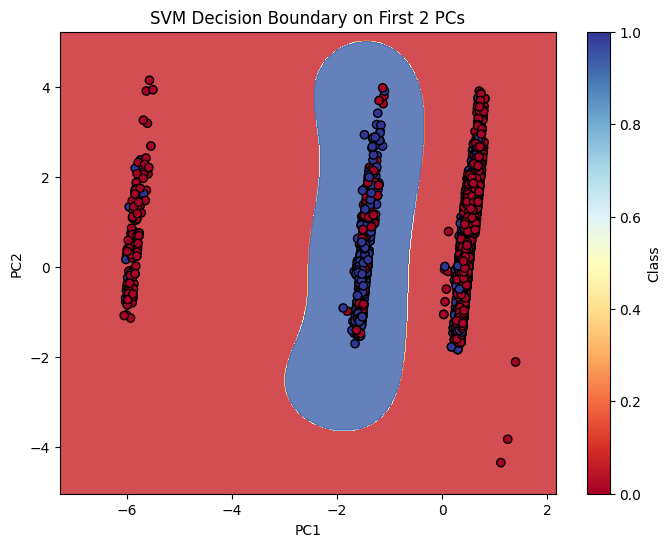

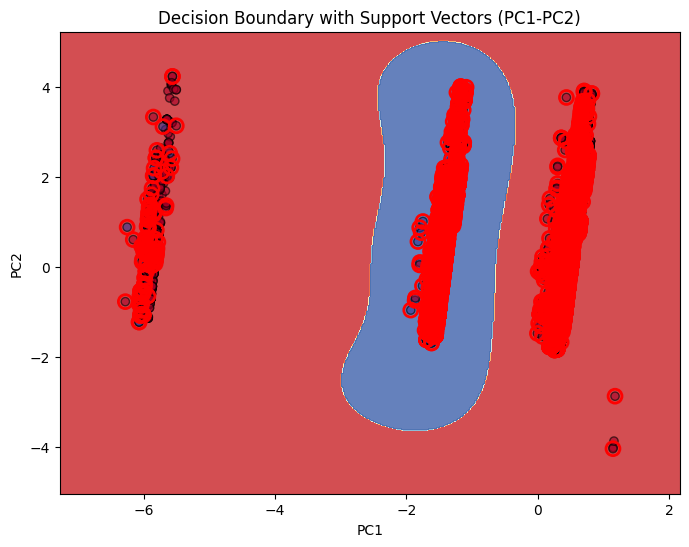

Mean reconstruction error on train (scaled space) with k=10: 0.0000
Features used: ['Age', 'type of account_cooperative', 'type of account_private', 'INACTIVE_YES', 'Mobile user_YES', 'has ATM CARD_yes', 'CURRENCY_EUR', 'CURRENCY_GBP', 'CURRENCY_USD', 'Job type_private', 'GENDER_MALE']
Number of original features: 11
Training samples: 24000
Test samples: 6000
Chosen PCA components: 10


In [18]:


    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
    scatter = plt.scatter(X_test_pc2[:, 0], X_test_pc2[:, 1], c=y_test, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title('SVM Decision Boundary on First 2 PCs')
    plt.colorbar(scatter, label='Class')
    plt.show()
    support_vectors = svm2.support_vectors_
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.scatter(X_train_pc2[:, 0], X_train_pc2[:, 1], c=y_train, cmap=plt.cm.RdYlBu, edgecolors='black', alpha=0.6)
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='red', linewidth=2)
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title('Decision Boundary with Support Vectors (PC1-PC2)')
    plt.show()

Xhat_train_scaled = pca.inverse_transform(X_train_pca)
recon_err_train = np.mean(np.sum((X_train_scaled - Xhat_train_scaled)**2, axis=1))
print(f"Mean reconstruction error on train (scaled space) with k={k}: {recon_err_train:.4f}")
feature_names = X.columns.tolist()
print("Features used:", feature_names)
print("Number of original features:", X.shape[1])
print("Training samples:", len(X_train_df))
print("Test samples:", len(X_test_df))
print("Chosen PCA components:", k)